In [1]:
import os
import sys
from datetime import datetime

In [2]:
# -------------------------------------------------------------
# Environment setup
# -------------------------------------------------------------
BASE_DIR = os.path.abspath("../")
sys.path.append(BASE_DIR)

# -------------------------------------------------------------
# Configuration
# -------------------------------------------------------------
from src.utils.config import load_config
config = load_config(base_dir=BASE_DIR)

# Selección automática del número de clusters K usando Score Combinado

## Delta Inertia - Elbow clasico

En K-Means, la **inercia** representa la suma de las distancias cuadradas de cada punto a su centroide:

$$
\text{Inertia} = \sum_{i=1}^{N} \|x_i - \mu_{c_i}\|^2
$$

- A medida que **K aumenta**, la inercia siempre disminuye, ya que los centros de los clusters están más cercanos a los puntos.  
- Para detectar el **codo (elbow)**, definimos:

$$
\Delta \text{Inertia}[k] = \text{Inertia}[k-1] - \text{Inertia}[k]
$$

- Este valor indica cuánto disminuye la inercia al aumentar K en 1. El “mejor” K suele estar donde la reducción significativa se detiene.

---

## Score Combinado

Para automatizar la elección del número de clusters, combinamos tres métricas internas:

1. **Silhouette Score**: mide cohesión y separación de los clusters.  
2. **Calinski–Harabasz (CH) Score**: mide densidad interna y separación de clusters.  
3. **Delta Inertia**: captura el codo en la inercia.

La fórmula del **score combinado** es:

$$
\text{Score Combinado}[k] =
\frac{\text{Silhouette Mean}[k]}{\text{Silhouette Var}[k] + \epsilon} +
\frac{\text{CH Mean}[k]}{\text{CH Var}[k] + \epsilon} +
\frac{\Delta \text{Inertia}[k]}{\text{Inertia Var}[k] + \epsilon}
$$

- \(\epsilon\) es un valor muy pequeño para evitar división por cero.  
- Cada término busca que la métrica sea **alta y estable** entre distintas corridas (runs) de K-Means.

| Componente           | Qué mide                        | Qué buscamos                  |
|---------------------|---------------------------------|-------------------------------|
| Silhouette Mean / Var | Cohesión y separación           | Alto y estable                |
| CH Mean / Var        | Separación y densidad de clusters | Alto y estable                |
| Delta Inertia / Var  | Cambio de inercia al aumentar K | Alto y estable (codo definido)|

---

## A Favor

- Integra **tres métricas diferentes** en un solo valor.  
- Permite seleccionar **automáticamente el mejor K** sin depender de la interpretación visual del codo.  
- Más robusto cuando se hacen **múltiples corridas** con distintas inicializaciones o muestras.

---

- El **K con el score combinado más alto** es el óptimo según estas métricas.  
- La metodología considera tanto **calidad de los clusters** como **estabilidad entre runs**.
- Como autor me inteereza tener una variedad de grupos, por eso penalizo los valores minimos


In [3]:
import time
import pickle

import dask.dataframe as dd

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

import matplotlib.pyplot as plt


In [4]:
tensors_normalized_L2 = config["paths"]["tensors_normalized_L2"]
tensors_normalized_L1 = config["paths"]["tensors_normalized_L1"]
tensors_svd = config["paths"]["tensors_svd"]
data = dd.read_parquet(tensors_normalized_L2)

# Separar ID y features
ids = data.iloc[:, 0]
features_df = data.iloc[:, 1:].astype('float64')

# CLAVE: Convertir DataFrame a Dask Array
features = features_df.to_dask_array(lengths=True)
print(f"Forma del array: {features.shape}")
print(f"Tipo: {type(features)}")

data.head()

Forma del array: (26283914, 30)
Tipo: <class 'dask.array.core.Array'>


,row_id,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,...,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29
0,+++AhJk2QJM=_0,0.18354383876223496,0.45835296900892575,0.025517409589218554,-0.37577015509789075,0.6105910994582527,0.10629629419904485,-0.14972054015942687,0.10750966385427094,0.017984026634486058,...,0.051608933093341636,0.021368221778374746,-0.08141520672915056,0.16977502204800538,0.16109029468825864,-0.05067097465264788,-0.06827706872011195,0.01483498453621462,-0.0657108412334203,-0.05110301354077164
1,+++AhJk2QJM=_1,-0.3731014032013893,-0.28556490422227143,0.5188125780116108,-0.1476144597055317,0.17034882695398001,0.03851895058864556,0.37611087567118584,0.14558864086450435,0.07532097858416593,...,0.04550809658950912,-0.044847801169892565,0.08959230725366724,0.09109483552926949,0.08873684295605751,-0.004493309785312243,-0.1948880183573171,0.034133060720072786,-0.08245490723348949,-0.009899876847821735
2,+++AhJk2QJM=_2,-0.7923395157836037,-0.19065466470554923,0.21820824554140686,-0.027691346025751015,0.16050045575632277,0.011565443278957897,0.18853840929390173,0.1187467406854858,0.09987762926126241,...,0.1615425678606119,-0.13958189053659648,0.033073953331254326,-0.007049707051690915,-0.0028075122488810974,0.008698332848963309,-0.007409171029307324,0.012163511997484751,0.11966869682971497,-0.051535078630086384
3,+++AhJk2QJM=_3,-0.6752671641372449,0.0672061585751418,-0.2948297045056082,-0.09708413476638934,0.2891499052983675,0.01157761755629259,0.05697407034042975,0.025385845022835595,-0.13228120384353334,...,-0.11366873380642441,-0.12274850397009605,-0.18736578387319355,-0.2067859267314851,0.11744501268371446,-0.04011887567169648,0.053616775450085565,-0.022940294162953484,-0.00684803936771585,-0.04338012165506535
4,+++AhJk2QJM=_4,-0.27398011244579595,-0.3724617282840114,0.025336322514982183,-0.2953801522142788,0.03339539107586864,0.3978171902469705,-0.13480253403259543,-0.04099300341699297,-0.15937066411533152,...,-0.2580397568289025,0.060662617602913374,-0.20796580507444654,-0.12646339974290038,0.130250646515922,-0.044343575665431754,0.10369114466971593,-0.027885793076874988,-0.022157167829511527,-0.03396374606363473


In [5]:
SAMPLE_FRACTION = 0.001
random_seed = 42
N_RUNS = 30
k_range = list(range(2, 65, 2))

montecarlo_metrics = {
    "config": {
        "sample_fraction": SAMPLE_FRACTION,
        "random_seed": random_seed,
        "n_runs": N_RUNS,
        "k_range": k_range
    },
    "runs": []
}

for run in range(N_RUNS):
    print(f"\n====== RUN {run+1}/{N_RUNS} ======")

    # Sample
    sample_df_dask = data.sample(
        frac=SAMPLE_FRACTION,
        random_state=random_seed + run
    )
    df = sample_df_dask.iloc[:, 1:].compute().astype("float64")

    print(f"Sample shape: {df.shape}")

    inertia_vals = []
    ch_vals = []
    sil_vals = []

    # K loop
    for k in k_range:
        # print(f"  k={k}")

        kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = kmeans.fit_predict(df)

        inertia_vals.append(kmeans.inertia_)
        ch_vals.append(calinski_harabasz_score(df, labels))
        sil_vals.append(silhouette_score(df, labels))

    montecarlo_metrics["runs"].append({
        "run_id": run,
        "sample_shape": df.shape,
        "inertia": inertia_vals,
        "calinski_harabasz": ch_vals,
        "silhouette": sil_vals
    })

# Save to pickle
with open("montecarlo_metrics.pkl", "wb") as f:
    pickle.dump(montecarlo_metrics, f)

print("\nProcesamiento terminado.")


====== RUN 1/30 ======
Sample shape: (26294, 30)

====== RUN 2/30 ======
Sample shape: (26294, 30)

====== RUN 3/30 ======
Sample shape: (26294, 30)

====== RUN 4/30 ======
Sample shape: (26294, 30)

====== RUN 5/30 ======
Sample shape: (26294, 30)

====== RUN 6/30 ======
Sample shape: (26294, 30)

====== RUN 7/30 ======
Sample shape: (26294, 30)

====== RUN 8/30 ======
Sample shape: (26294, 30)

====== RUN 9/30 ======
Sample shape: (26294, 30)

====== RUN 10/30 ======
Sample shape: (26294, 30)

====== RUN 11/30 ======
Sample shape: (26294, 30)

====== RUN 12/30 ======
Sample shape: (26294, 30)

====== RUN 13/30 ======
Sample shape: (26294, 30)

====== RUN 14/30 ======
Sample shape: (26294, 30)

====== RUN 15/30 ======
Sample shape: (26294, 30)

====== RUN 16/30 ======
Sample shape: (26294, 30)

====== RUN 17/30 ======
Sample shape: (26294, 30)

====== RUN 18/30 ======
Sample shape: (26294, 30)

====== RUN 19/30 ======
Sample shape: (26294, 30)

====== RUN 20/30 ======
Sample shape: (

In [19]:
import pickle

with open("clustering_results.pkl", "wb") as f:
    pickle.dump(montecarlo_metrics, f)

montecarlo_metrics["runs"][0]["sample_shape"]
montecarlo_metrics["runs"][0].keys()

dict_keys(['run_id', 'sample_shape', 'inertia', 'calinski_harabasz', 'silhouette'])

In [23]:

# Cargar metricas desde el diccionario
runs = montecarlo_metrics["runs"]
k_values = np.array(montecarlo_metrics["config"]["k_range"])

# Convertir listas de runs → matrices numpy
inertia_arr = np.array([r["inertia"] for r in runs])
ch_arr      = np.array([r["calinski_harabasz"] for r in runs])
sil_arr     = np.array([r["silhouette"] for r in runs])

# Estadisticas
inertia_median = np.median(inertia_arr, axis=0)
ch_median      = np.median(ch_arr, axis=0)
sil_median     = np.median(sil_arr, axis=0)

inertia_std = np.std(inertia_arr, axis=0)
ch_std      = np.std(ch_arr, axis=0)
sil_std     = np.std(sil_arr, axis=0)

# Elbow automatico
scaler = MinMaxScaler()
inertia_scaled = scaler.fit_transform(inertia_median.reshape(-1, 1)).flatten()
second_diff = np.diff(np.diff(inertia_scaled))
elbow_k = k_values[np.argmax(np.abs(second_diff)) + 2]
elbow_score = 1 - (np.abs(k_values - elbow_k) / np.abs(k_values - elbow_k).max())

# Normalizacion
inertia_norm = 1 - inertia_scaled
ch_norm  = scaler.fit_transform(ch_median.reshape(-1, 1)).flatten()
sil_norm = scaler.fit_transform(sil_median.reshape(-1, 1)).flatten()

# Penalizacion
k_min_threshold = 6
LOG_BASE = 1000
max_log = np.log(LOG_BASE)
k_start = k_values[0]

k_penalty = np.ones(len(k_values))
for i, k in enumerate(k_values):
    if k < k_min_threshold:
        lf = max(0, (k - k_start) / (k_min_threshold - k_start))
        k_penalty[i] = np.log(1 + lf * (LOG_BASE - 1)) / max_log

# Estabilidad
cv = (
    inertia_std / (inertia_median + 1e-10) +
    ch_std      / (ch_median + 1e-10) +
    sil_std     / (np.abs(sil_median) + 1e-10)
) / 3

stability_score = 1 - scaler.fit_transform(cv.reshape(-1, 1)).flatten()

# Score combinado
combined_score = (
    0.20 * inertia_norm +
    0.20 * ch_norm +
    0.20 * sil_norm +
    0.20 * elbow_score +
    0.20 * stability_score
) * k_penalty


# Tabla final
results_df = pd.DataFrame({
    "k": k_values,
    "combined_score": combined_score,
    "inertia_norm": inertia_norm,
    "ch_norm": ch_norm,
    "sil_norm": sil_norm,
    "elbow_score": elbow_score,
    "stability_score": stability_score,
    "penalty": k_penalty
}).sort_values("combined_score", ascending=False).reset_index(drop=True)

best_k = int(results_df.loc[0, "k"])
print("BEST K:", best_k)

results_df.head()

BEST K: 42


,k,combined_score,inertia_norm,ch_norm,sil_norm,elbow_score,stability_score,penalty
0,42,0.610345,0.919939,0.061442,0.930330,0.379310,0.760703,1.0
1,44,0.607541,0.930410,0.054208,0.946900,0.344828,0.761360,1.0
2,40,0.602703,0.908391,0.067797,0.919186,0.413793,0.704347,1.0
3,46,0.602063,0.939699,0.047718,0.938712,0.310345,0.773841,1.0
4,52,0.601004,0.965191,0.031044,0.988225,0.206897,0.813664,1.0


In [24]:
results_sorted_k = results_df.sort_values('k').reset_index(drop=True)

k_opt_inertia = results_sorted_k.iloc[results_sorted_k['inertia_norm'].idxmax()]['k']
k_opt_ch = results_sorted_k.iloc[results_sorted_k['ch_norm'].idxmax()]['k']
k_opt_sil = results_sorted_k.iloc[results_sorted_k['sil_norm'].idxmax()]['k']
k_opt_elbow_score = results_sorted_k.iloc[results_sorted_k['elbow_score'].idxmax()]['k']
k_opt_stability = results_sorted_k.iloc[results_sorted_k['stability_score'].idxmax()]['k']
k_opt_combined = int(results_df.iloc[0]['k'])

summary_data = {
    'Métrica': [
        'Score Combinado Final (Consenso)',
        'Inercia Normalizada',
        'Calinski-Harabasz',
        'Silhouette Score',
        'Elbow Score',
        'Score de Estabilidad'
    ],
    'K Óptimo Sugerido': [
        k_opt_combined,
        k_opt_inertia,
        k_opt_ch,
        k_opt_sil,
        k_opt_elbow_score,
        k_opt_stability
    ]
}
best_score = results_sorted_k.loc[results_sorted_k['k'] == best_k, 'combined_score'].iloc[0]
print("Best Score:", best_score)
summary_df = pd.DataFrame(summary_data)
summary_df

Best Score: 0.6103448432450628


,Métrica,K Óptimo Sugerido
0,Score Combinado Final (Consenso),42.0
1,Inercia Normalizada,64.0
2,Calinski-Harabasz,2.0
3,Silhouette Score,64.0
4,Elbow Score,6.0
5,Score de Estabilidad,2.0


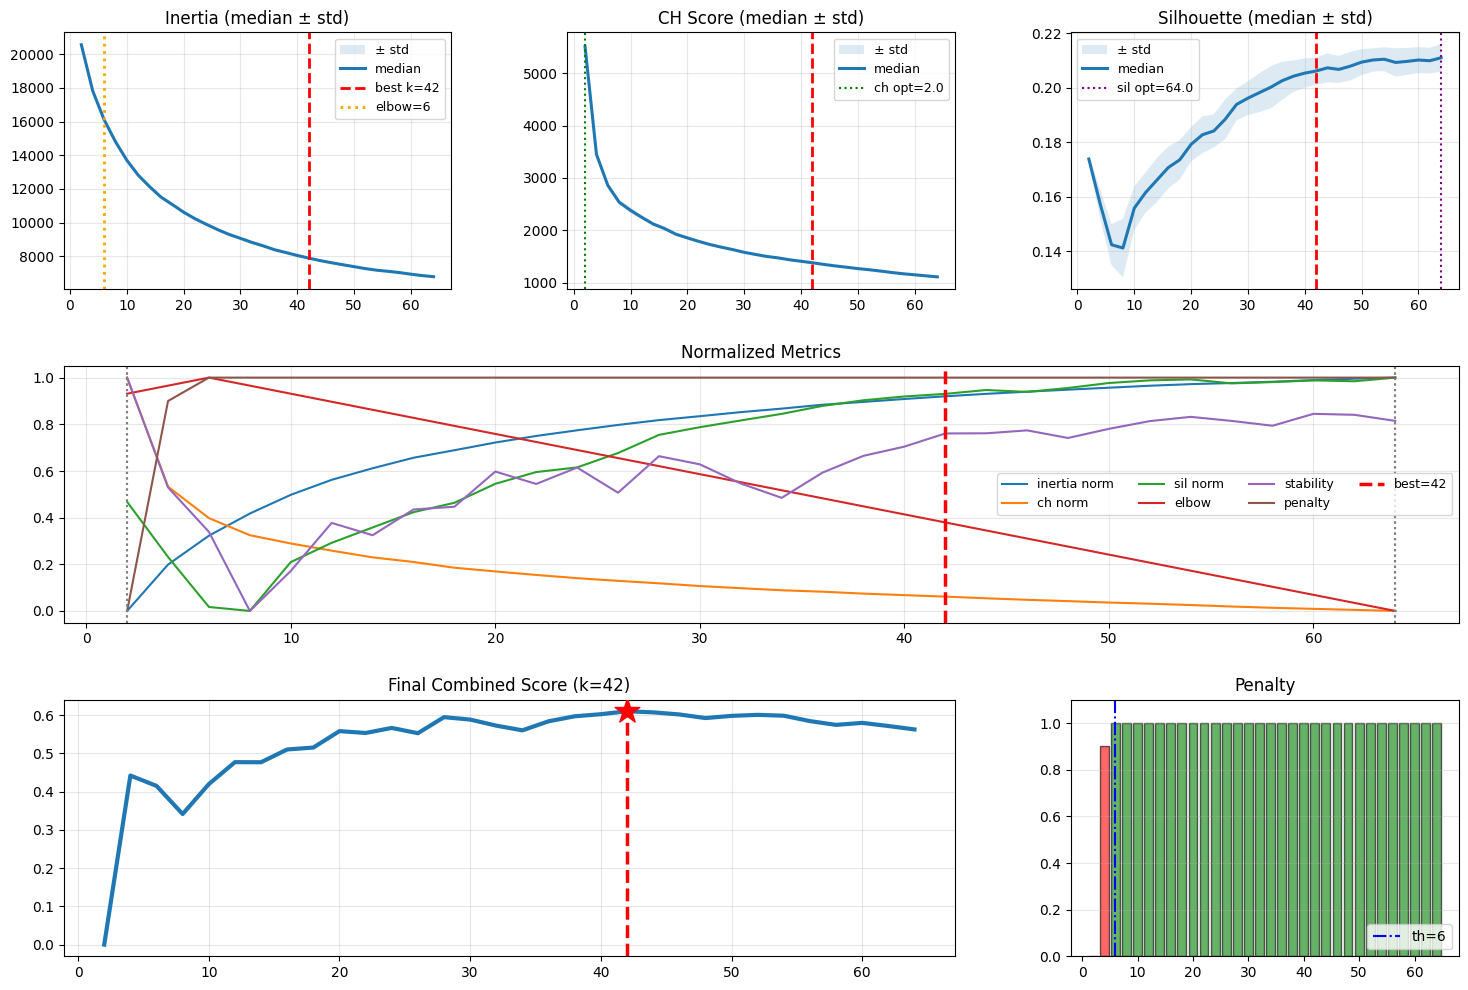

In [25]:
# =============================================================================
# VISUALIZACIÓN MEJORADA (MEDIANAS + STD)
# =============================================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

results_sorted = results_df.sort_values('k')

# --- Plot 1: Inercia ---
ax1 = fig.add_subplot(gs[0, 0])
ax1.fill_between(k_values, inertia_median - inertia_std, inertia_median + inertia_std,
                 alpha=0.15, label='± std')
ax1.plot(k_values, inertia_median, '-', linewidth=2.2, label='median')
ax1.axvline(best_k, color='red', linestyle='--', linewidth=2, label=f'best k={best_k}')
ax1.axvline(elbow_k, color='orange', linestyle=':', linewidth=2, label=f'elbow={elbow_k}')
ax1.set_title('Inertia (median ± std)')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# --- Plot 2: CH Score ---
ax2 = fig.add_subplot(gs[0, 1])
ax2.fill_between(k_values, ch_median - ch_std, ch_median + ch_std,
                 alpha=0.15, label='± std')
ax2.plot(k_values, ch_median, '-', linewidth=2.2, label='median')
ax2.axvline(best_k, color='red', linestyle='--', linewidth=2)
ax2.axvline(k_opt_ch, color='green', linestyle=':', linewidth=1.5, label=f'ch opt={k_opt_ch}')
ax2.set_title('CH Score (median ± std)')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# --- Plot 3: Silhouette ---
ax3 = fig.add_subplot(gs[0, 2])
ax3.fill_between(k_values, sil_median - sil_std, sil_median + sil_std,
                 alpha=0.15, label='± std')
ax3.plot(k_values, sil_median, '-', linewidth=2.2, label='median')
ax3.axvline(best_k, color='red', linestyle='--', linewidth=2)
ax3.axvline(k_opt_sil, color='purple', linestyle=':', linewidth=1.5, label=f'sil opt={k_opt_sil}')
ax3.set_title('Silhouette (median ± std)')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# --- Plot 4: Métricas Normalizadas ---
ax4 = fig.add_subplot(gs[1, :])
ax4.plot(results_sorted['k'], results_sorted['inertia_norm'], label='inertia norm')
ax4.plot(results_sorted['k'], results_sorted['ch_norm'], label='ch norm')
ax4.plot(results_sorted['k'], results_sorted['sil_norm'], label='sil norm')
ax4.plot(results_sorted['k'], results_sorted['elbow_score'], label='elbow')
ax4.plot(results_sorted['k'], results_sorted['stability_score'], label='stability')
ax4.plot(results_sorted['k'], results_sorted['penalty'], label='penalty')
ax4.axvline(best_k, color='red', linestyle='--', linewidth=2.5, label=f'best={best_k}')
ax4.axvline(k_opt_inertia, color='gray', linestyle=':', linewidth=1.5)
ax4.axvline(k_opt_ch, color='gray', linestyle=':', linewidth=1.5)
ax4.axvline(k_opt_sil, color='gray', linestyle=':', linewidth=1.5)
ax4.axvline(k_opt_stability, color='gray', linestyle=':', linewidth=1.5)
ax4.set_title('Normalized Metrics')
ax4.legend(ncol=4, fontsize=9)
ax4.grid(True, alpha=0.3)

# --- Plot 5: Combined Score ---
ax5 = fig.add_subplot(gs[2, :2])
ax5.plot(results_sorted['k'], results_sorted['combined_score'], '-', linewidth=3)
ax5.axvline(best_k, color='red', linestyle='--', linewidth=2.5)
ax5.scatter([best_k], [best_score], s=350, c='red', marker='*', zorder=5)
ax5.set_title(f'Final Combined Score (k={best_k})')
ax5.grid(True, alpha=0.3)

# --- Plot 6: Penalty ---
ax6 = fig.add_subplot(gs[2, 2])
colors = ['red' if p < 1 else 'green' for p in results_sorted['penalty']]
ax6.bar(results_sorted['k'], results_sorted['penalty'],
        width=(k_values[1] - k_values[0]) * 0.8,
        color=colors, alpha=0.6, edgecolor='black')
ax6.axvline(k_min_threshold, color='blue', linestyle='-.', linewidth=1.5, label=f'th={k_min_threshold}')
ax6.set_title('Penalty')
ax6.set_ylim([0, 1.1])
ax6.legend(loc='lower right')
ax6.grid(True, alpha=0.3, axis='y')

plt.show()

